# Self-Driving Car Engineer Nanodegree
# **Finding Lane Lines on the Road** 


## Introduction 
***

The main goal of this project is to detect and identify the lane lines with high accuracies for some real images and video streams. The challenge is to extract those lane lines and identify them without any external distortions from the surrounding environment. This project is programmed using Python and OpenCV library for the Image processing and Computer vision. Throughout this document, the pipeline of the code implementation will be demonstrated and some reflections on how it was successfully executed will be presented as well.

---

### Reflection

### 1. Pipeline Description. 

**Images Conversion from RGB to HLS**

The proposed pipeline in this work consists of 6 steps. First, the images were transformed from RGB to HLS to get all the colors with high Lightness (above 200) which means in the high brightness region such as the White lane lines. The Yellow lanes were however detected with less Lightness but Hue values in the range between 10 and 40 and Lightness above 100. The two image masks for the white and yellow colors are then added together (Bitwise OR) and the "select_white_yellow" function returns the image with only both colors.

*Figure 1: White and Yellow Lane Colors in HLS*

![White_Lane](./writeup_images/WYLane_HSL.PNG "White and Yellow Lane Colors")

---

**Modifications on the draw_lines() function**

In fact we assume that the camera angle and optical zoom are fixed, hence we predict to have the lane lines drawn from the Hough transform within a limited predictable area and slopes. The "draw_lines(...)" function takes the image, the Hough lines, Result Line Color and thickness as its parameters. First, we get the resolution of the image first (image.shape), then for each line with (x1,y1,x2,y2) the slope is calculated and checked. If the slope is greater than Zero and x1 & x2 are greater than half the X-Resolution (image width/2), then the points are added to the Right Lane Rx and Ry data arrays, else if slope is less than zero and x1 & x2 are less than half the resolution, then the points are added to the Left Lane Lx and Ly data arrays. Then the function "cv2.polyfit(...)" is used to fit the Right and Left Lane lines respectively and draw only a first degree order line for each lane using the function "cv2.line(...)" for each frame independently.

*Example*

Lxdata = [290, 451, 281, 333, 294, 452, 281, 450, 289, 419, 337, 416, 292, 452]

Lydata = [462, 332, 462, 419, 461, 333, 460, 332, 462, 357, 416, 356, 462, 332]

Rxdata = [530, 878, 532, 897, 530, 897, 530, 877, 609, 777]

Rydata = [337, 538, 336, 538, 336, 539, 338, 538, 382, 479]

---

## Import Packages & Define Functions

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

def select_white_yellow(image):
    """Image transformation from RGB to HLS,
    then the White & Yellow colors are detected & combined together"""
    # convert to HLS
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines_basic(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    The draw_lines() function first checks the slopes ((y2-y1)/(x2-x1)) of the provided Hough lines
    If greater then Zero and the points x1, x2 are greater than half the X-resolution, then it's a Right Lane
    If less then Zero and the points x1, x2 are less than half the X-resolution, then it's a Left Lane
    The cv2.polyfit() function is used to average and extrapolate the line segments to the top & bottom of the lane.
    This function then draws the final fitted lines for the Right and Left lanes respectively. 
    """
   
    yRes = img.shape[0]
    xRes = img.shape[1]
    print (img.shape)
    slope = 0 # np.zeros(len(lines))
    #Offsets = np.zeros(len(lines))
    
    Lxdata = []
    Lydata = []
    
    Rxdata = []
    Rydata = []
    LCount = 0
    RCount = 0
    
    for idx, line in enumerate(lines): # If x1,x2<xRes/2 however slope>0, then DISMISS that LINE (To be Handled)
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)              # np.array((y2-y1)/(x2-x1),dtype='f')
            if slope<0 and slope>-2 and x1<xRes/2 and x2<xRes/2:
                Lxdata.extend([x1,x2])
                Lydata.extend([y1,y2])
                # print ("Lslope = "+str(slope)+"Lxdata = "+str(Lxdata)+"Lydata = "+str(Lydata))
                LCount += 1
            elif slope>0 and slope<2 and x1>xRes/2 and x2>xRes/2:
                Rxdata.extend([x1,x2])
                Rydata.extend([y1,y2])
               # print ("Rslope = "+str(slope)+"Rxdata = "+str(Rxdata)+"Rydata = "+str(Rydata))
                RCount += 1
            else:
                print ("Line Invalid :: "+str(line))
# #             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#     print ("Lxdata = "+str(Lxdata)+",\nLydata = "+str(Lydata))
#     print ("Rxdata = "+str(Rxdata)+",\nRydata = "+str(Rydata))
    
    y2 = int(6*yRes/10)
     
    if (LCount != 0): 
        LFit = np.polyfit(Lxdata, Lydata, 1)
        #Left Lane
        cv2.line(img, (int((yRes-LFit[1])/LFit[0]), yRes), (int((y2-LFit[1])/LFit[0]), y2), color, thickness)
        
    if (RCount != 0):    
        RFit = np.polyfit(Rxdata, Rydata, 1)
        #Right Lane
        cv2.line(img, (int((yRes-RFit[1])/RFit[0]), yRes), (int((y2-RFit[1])/RFit[0]), y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



The pipelinefor drawing the lane lines is built and run all the test_images. The results will be copied to the `test_images_output` directory.

In [ ]:
import os
imagelist = os.listdir("test_images/")
#print (imagelist)

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
for imagename in imagelist:
    
    print (imagename)
    image = mpimg.imread('test_images/'+imagename)
    #image = mpimg.imread('test_images/solidWhiteRight.jpg')
    
    # Make the Bitwise combination of only White & Yellow Colors
    white_yellow_img = select_white_yellow(image) 
    
    #grayscale conversion
    gray = grayscale(white_yellow_img) 

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    plt.imshow(blur_gray, cmap='gray')
    plt.show()

    # Define parameters for Canny
    low_threshold = 60
    high_threshold = 100
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    plt.imshow(edges, cmap='Greys_r')
    plt.show()

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    img_height = image.shape[0] # 540
    img_width = image.shape[1]  # 960
    
    # Set the Vertices generally according to the Resolution
    vertices = np.array([[(30, img_height),
                          ((img_width/2)-(img_width/16), 6 * img_height / 10),
                          ((img_width/2)+(img_width/16), 6 * img_height / 10),
                          (img_width-30, img_height) ]],
                          dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)

#     plt.imshow(masked_edges)
#     plt.show()

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell) 50
    min_line_length = 20 #minimum number of pixels making up a line 1
    max_line_gap = 300   # maximum gap in pixels between connectable line segments 900
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image with ROI
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
 
    overlay = np.copy(image)
    
    draw_lines(overlay,lines, color=[255, 0, 0], thickness=15)
    # draw_lines(lines_edges,lines, color=[255, 0, 0], thickness=15)
    

    """If you want to make the lines semi-transparent, then use the addWeighted() function after drawing then lines"""
    opacity = 0.6
    cv2.addWeighted(image, opacity, overlay, 1-opacity, 0, overlay)
    #cv2.addWeighted(overlay, opacity, lines_edges, 1-opacity, 0, lines_edges)
    
    cv2.imwrite('test_images_output/'+imagename,overlay)
    #cv2.imwrite(str(imagename), imagename)
    
    plt.imshow(overlay)
    plt.show()


**Main Running Code Implementation**

1. Image is transformed from RGB to the HLS, then the Yellow and White image masks are added together (Bitwise OR).
![Bitwise_W&Y_Colors](./writeup_images/Bitwise_W_Y.png "Bitwise_W&Y Image")
2. Grayscale conversion
3. Gaussian Smoothing (Blurring image before applying the Canny edge detector filter)
4. Apply the Canny Edge Detector filter with Low and High Thresholds of 60 and 100 respectively.
![Canny](./writeup_images/Canny.png "Canny")
5. Apply the Region of Interest function with the vertices of a Polygon-shaped mask to define the area of the lanes in the image.
6. Apply the Hough Transform on the resulted image (Edge detected image with ROI) to get the possible lines.
7. Apply the draw_lines(..) function to draw a final averaged thick line for each lane from the Hough lines.
8. Apply the weighted_img() function to make the final lines semi transparent over the original photo.
![Final](./writeup_images/Result.png "Final Image")

## Test on Videos

**You know what's cooler than drawing lanes over images? Drawing lanes over video!**

We will test our solution on three provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

`challenge.mp4`


In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    white_yellow_img = select_white_yellow(image) # Extract the White and Yellow Colors
    gray = grayscale(white_yellow_img) #grayscale conversion

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

#     plt.imshow(blur_gray, cmap='gray')
#     plt.show()

    # Define parameters for Canny and run it
    low_threshold = 60    
    high_threshold = 100  
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
        
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    img_height = image.shape[0] # 540
    img_width = image.shape[1]  # 960
    
    # Set the Vertices generally according to the Resolution (Polygon of 4 Vertices)
    vertices = np.array([[(30, img_height),
                          ((img_width/2)-(img_width/16), 6 * img_height / 10),
                          ((img_width/2)+(img_width/16), 6 * img_height / 10),
                          (img_width-30, img_height) ]],
                          dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)

#     plt.imshow(masked_edges)
#     plt.show()
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 15       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 300   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
 
    overlay = np.copy(image)
    
    draw_lines(overlay,lines, color=[255, 0, 0], thickness=15)
    # draw_lines(lines_edges,lines, color=[255, 0, 0], thickness=15)
    
    """If you want to make the lines semi-transparent, then use the addWeighted() function after drawing then lines"""
    opacity = 0.6
    cv2.addWeighted(image, opacity, overlay, 1-opacity, 0, overlay)
    
    result = overlay
    
    plt.imshow(overlay)
    plt.show()

    return result

---

**Solid White Right Lane Test**

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,2)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

*Play the video inline:*

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

---

**Solid Yellow Left Lane Test**

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,2)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

*Play the video inline:*

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

---

**Challenge Lane Test**


(720, 1280, 3)
Line Invalid :: [[260 687 281 687]]


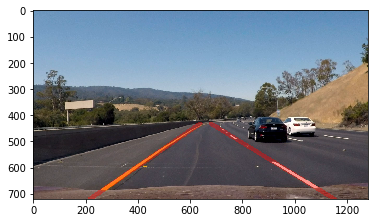

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                   | 0/51 [00:00<?, ?it/s]

(720, 1280, 3)
Line Invalid :: [[260 687 281 687]]


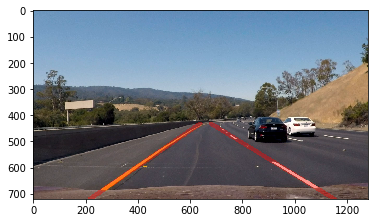

  2%|▊                                          | 1/51 [00:00<00:16,  3.08it/s]

(720, 1280, 3)
Line Invalid :: [[259 686 279 687]]


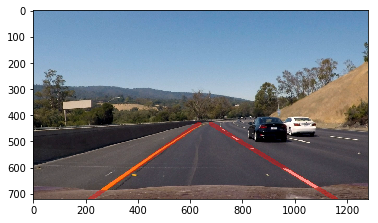

  4%|█▋                                         | 2/51 [00:00<00:16,  2.93it/s]

(720, 1280, 3)


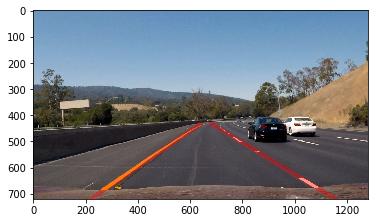

  6%|██▌                                        | 3/51 [00:01<00:16,  3.00it/s]

(720, 1280, 3)


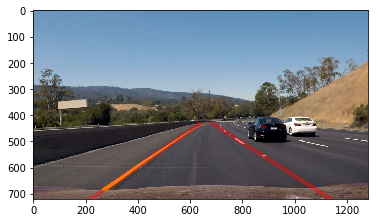

  8%|███▎                                       | 4/51 [00:01<00:15,  2.94it/s]

(720, 1280, 3)


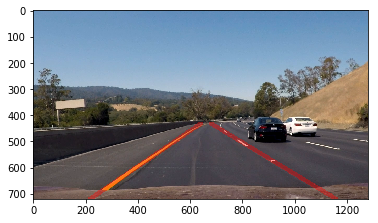

 10%|████▏                                      | 5/51 [00:01<00:15,  2.97it/s]

(720, 1280, 3)


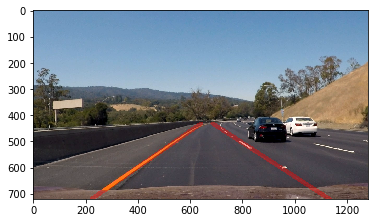

 12%|█████                                      | 6/51 [00:02<00:15,  2.98it/s]

(720, 1280, 3)


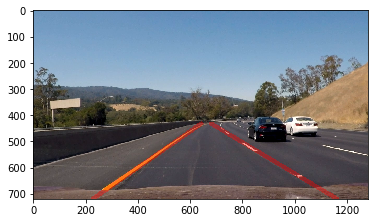

 14%|█████▉                                     | 7/51 [00:02<00:14,  3.00it/s]

(720, 1280, 3)


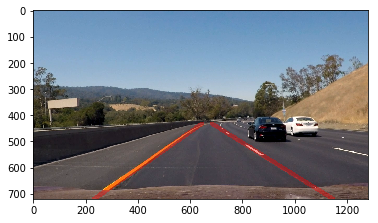

 16%|██████▋                                    | 8/51 [00:02<00:14,  3.01it/s]

(720, 1280, 3)


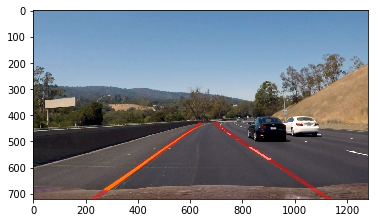

 18%|███████▌                                   | 9/51 [00:03<00:14,  3.00it/s]

(720, 1280, 3)


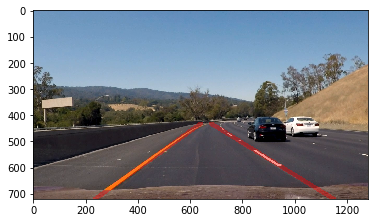

 20%|████████▏                                 | 10/51 [00:03<00:13,  3.01it/s]

(720, 1280, 3)
Line Invalid :: [[277 686 297 687]]


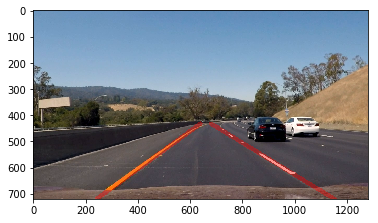

 22%|█████████                                 | 11/51 [00:03<00:13,  3.02it/s]

(720, 1280, 3)


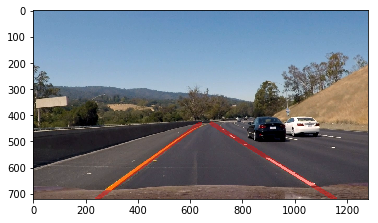

 24%|█████████▉                                | 12/51 [00:03<00:12,  3.03it/s]

(720, 1280, 3)


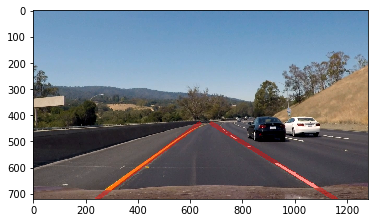

 25%|██████████▋                               | 13/51 [00:04<00:12,  3.00it/s]

(720, 1280, 3)
Line Invalid :: [[366 634 403 635]]


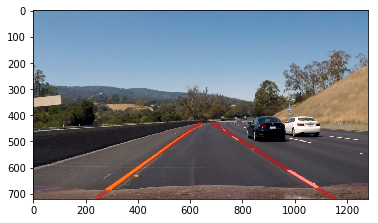

 27%|███████████▌                              | 14/51 [00:04<00:12,  3.01it/s]

(720, 1280, 3)
Line Invalid :: [[211 671 343 678]]
Line Invalid :: [[275 685 333 685]]


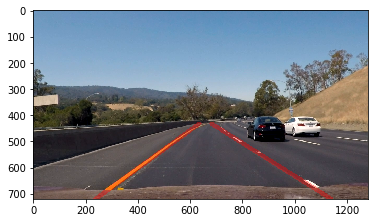

 29%|████████████▎                             | 15/51 [00:05<00:12,  2.96it/s]

(720, 1280, 3)


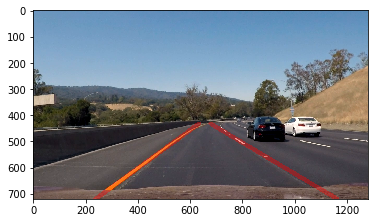

 31%|█████████████▏                            | 16/51 [00:05<00:11,  2.96it/s]

(720, 1280, 3)
Line Invalid :: [[277 684 297 685]]


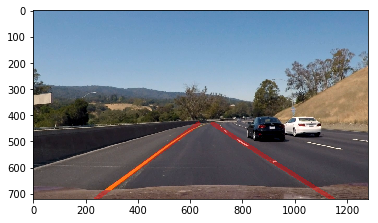

 33%|██████████████                            | 17/51 [00:05<00:11,  2.97it/s]

(720, 1280, 3)
Line Invalid :: [[278 685 302 685]]


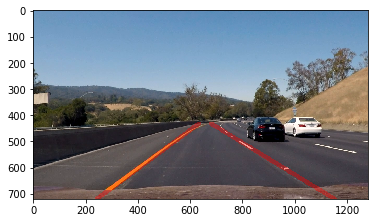

 35%|██████████████▊                           | 18/51 [00:06<00:11,  2.98it/s]

(720, 1280, 3)
Line Invalid :: [[1006  636 1037  636]]


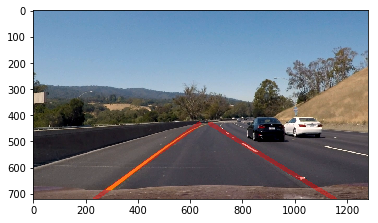

 37%|███████████████▋                          | 19/51 [00:06<00:10,  2.98it/s]

(720, 1280, 3)


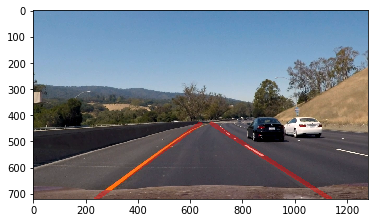

 39%|████████████████▍                         | 20/51 [00:06<00:10,  2.96it/s]

(720, 1280, 3)


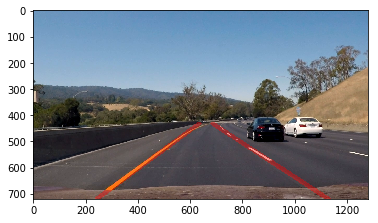

 41%|█████████████████▎                        | 21/51 [00:07<00:10,  2.97it/s]

(720, 1280, 3)
Line Invalid :: [[276 684 298 685]]


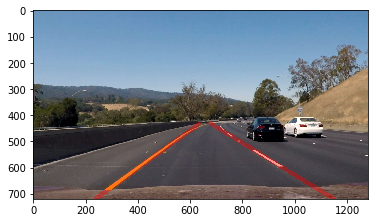

 43%|██████████████████                        | 22/51 [00:07<00:09,  2.98it/s]

(720, 1280, 3)


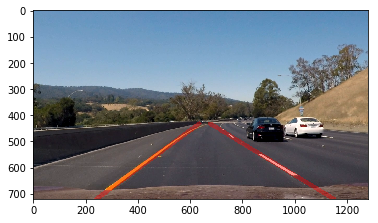

 45%|██████████████████▉                       | 23/51 [00:07<00:09,  2.97it/s]

(720, 1280, 3)


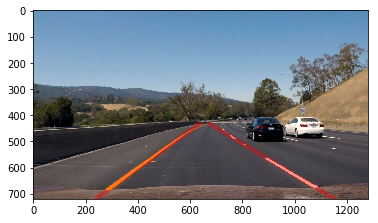

 47%|███████████████████▊                      | 24/51 [00:08<00:09,  2.98it/s]

(720, 1280, 3)
Line Invalid :: [[276 685 297 685]]


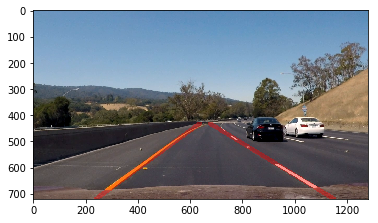

 49%|████████████████████▌                     | 25/51 [00:08<00:08,  2.98it/s]

(720, 1280, 3)


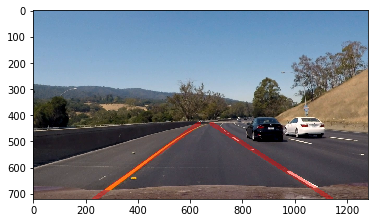

 51%|█████████████████████▍                    | 26/51 [00:08<00:08,  2.97it/s]

(720, 1280, 3)
Line Invalid :: [[191 682 295 685]]


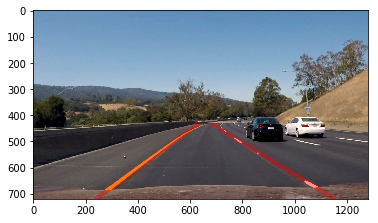

 53%|██████████████████████▏                   | 27/51 [00:09<00:08,  2.97it/s]

(720, 1280, 3)


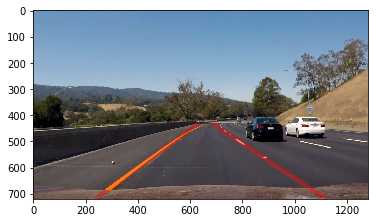

 55%|███████████████████████                   | 28/51 [00:09<00:07,  2.98it/s]

(720, 1280, 3)


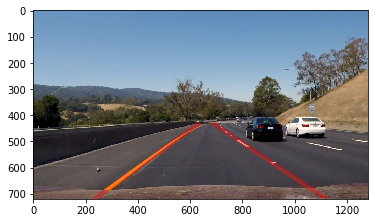

 57%|███████████████████████▉                  | 29/51 [00:09<00:07,  2.98it/s]

(720, 1280, 3)


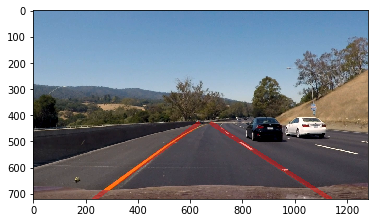

 59%|████████████████████████▋                 | 30/51 [00:10<00:07,  2.98it/s]

(720, 1280, 3)
Line Invalid :: [[1010  645 1037  644]]


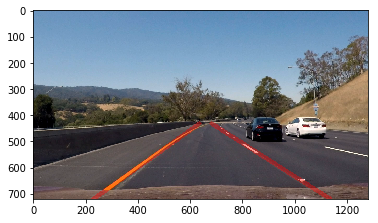

 61%|█████████████████████████▌                | 31/51 [00:10<00:06,  2.98it/s]

(720, 1280, 3)


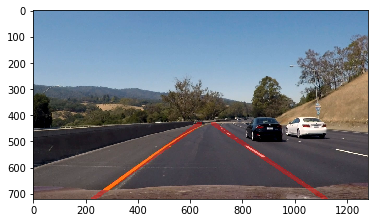

 63%|██████████████████████████▎               | 32/51 [00:10<00:06,  2.98it/s]

(720, 1280, 3)
Line Invalid :: [[269 685 291 685]]


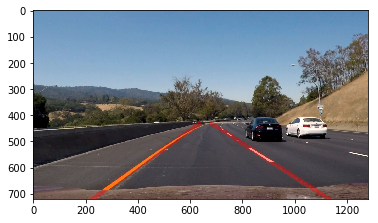

 65%|███████████████████████████▏              | 33/51 [00:11<00:06,  2.98it/s]

(720, 1280, 3)


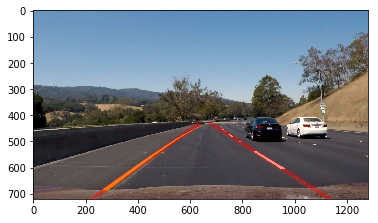

 67%|████████████████████████████              | 34/51 [00:11<00:05,  2.98it/s]

(720, 1280, 3)


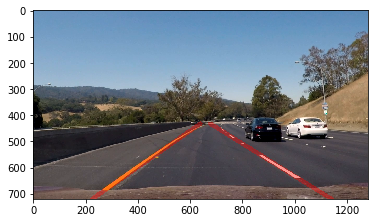

 69%|████████████████████████████▊             | 35/51 [00:11<00:05,  2.98it/s]

(720, 1280, 3)
Line Invalid :: [[262 686 283 687]]


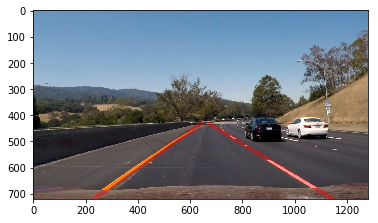

 71%|█████████████████████████████▋            | 36/51 [00:12<00:05,  2.99it/s]

(720, 1280, 3)


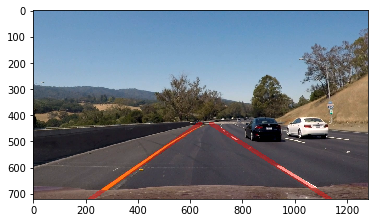

 73%|██████████████████████████████▍           | 37/51 [00:12<00:04,  2.97it/s]

(720, 1280, 3)
Line Invalid :: [[1063  677 1084  677]]


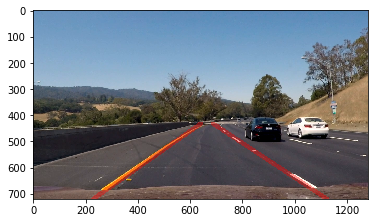

 75%|███████████████████████████████▎          | 38/51 [00:12<00:04,  2.97it/s]

(720, 1280, 3)
Line Invalid :: [[1064  677 1085  677]]


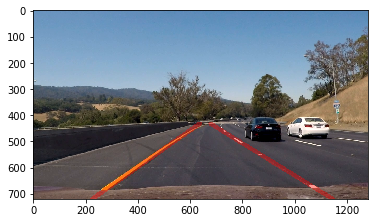

 76%|████████████████████████████████          | 39/51 [00:13<00:04,  2.97it/s]

(720, 1280, 3)


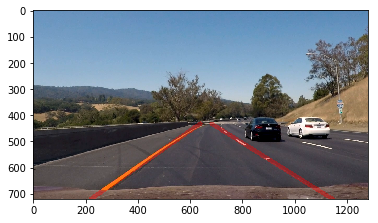

 78%|████████████████████████████████▉         | 40/51 [00:13<00:03,  2.97it/s]

(720, 1280, 3)


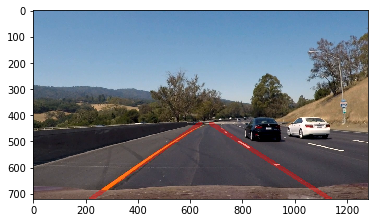

 80%|█████████████████████████████████▊        | 41/51 [00:13<00:03,  2.98it/s]

(720, 1280, 3)


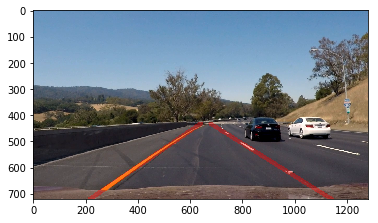

 82%|██████████████████████████████████▌       | 42/51 [00:14<00:03,  2.97it/s]

(720, 1280, 3)
Line Invalid :: [[1033  657 1058  654]]


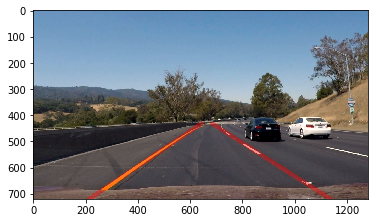

 84%|███████████████████████████████████▍      | 43/51 [00:14<00:02,  2.97it/s]

(720, 1280, 3)


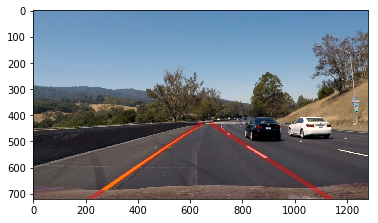

 86%|████████████████████████████████████▏     | 44/51 [00:14<00:02,  2.98it/s]

(720, 1280, 3)


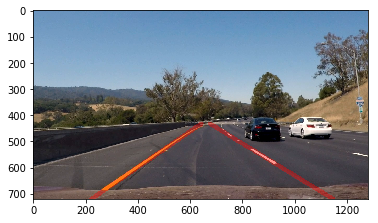

 88%|█████████████████████████████████████     | 45/51 [00:15<00:02,  2.97it/s]

(720, 1280, 3)


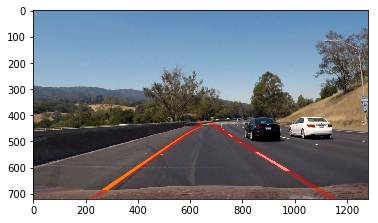

 90%|█████████████████████████████████████▉    | 46/51 [00:15<00:01,  2.97it/s]

(720, 1280, 3)


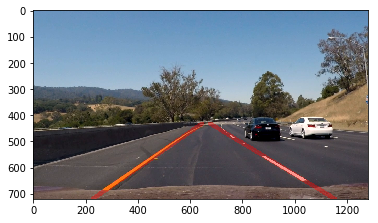

 92%|██████████████████████████████████████▋   | 47/51 [00:15<00:01,  2.96it/s]

(720, 1280, 3)


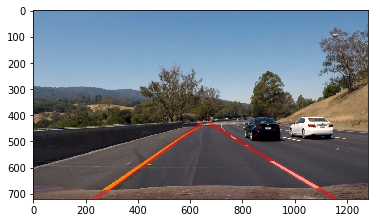

 94%|███████████████████████████████████████▌  | 48/51 [00:16<00:01,  2.94it/s]

(720, 1280, 3)


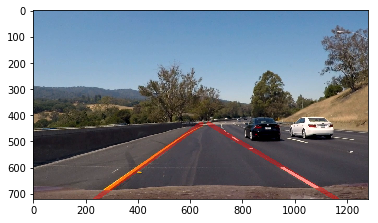

 96%|████████████████████████████████████████▎ | 49/51 [00:16<00:00,  2.94it/s]

(720, 1280, 3)
Line Invalid :: [[1069  676 1092  676]]


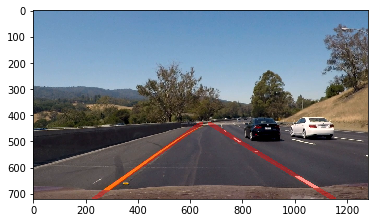

 98%|█████████████████████████████████████████▏| 50/51 [00:17<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 18.6 s


In [3]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

*Play the video inline:*

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))



### 2. Potential shortcomings

The transformation from the RGB to the HLS domain, then bitwising the White and yellow images made a huge and extremely effective improvement to the detection of the lane lined with a huge accuracy of around 100% on all the given samples including the Challenge problem. However, this project still assumes that there are no obstacles (i.e. other cars) close to the vehicle's front view which would cause some occulusions. Also it was assumed that the weather conditions are clear. Of course, the HLS domain overcame the challenge of different brightness due to shadows or different weather conditions which made the implementation very robust.

A possible shortcoming would appear with more curvy lane lines as well, which would make the hough transform with the given set parameters produce less lines or possibly would not be identified as lines. 

---

### 3. Suggest possible improvements to your pipeline

A possible improvement for the curvy lane lines would be to use higher order fitting polynomial to follow the lane curvature, but this would be a challenge as well since it will consume more computational time.

---

### 4. Reflections on the provided Feedback from Submission 1

**1. Add the write up into the ipython notebook**

Regarding the write up, I agree it would have been better to be added to the ipython notebook. However, I just followed what was demanded in the first section:"In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document." 

**2. Some videos are not compiling**

It occurred sometimes that the "handle is invalid" and I had to restart the kernel again. I don't know exactly what the required directories for the videos are, shall I push any specific folders/files to the Github directory?

**3. Linear Regression on finding the lane lines**

I used the Polynomial fitting cv2.polyfit() which is similar to the Regression technique after listing the points between the Left and the Right lanes to fit a linear line between all the provided points. 
